In [ ]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


<img src='../../../common/logo_DH.png' align='left' width=35%/>

# ML BigQuery

## Intro

BigQuery ML permite a los usuarios crear y ejecutar modelos de aprendizaje automático en BigQuery mediante consultas de SQL.

Vamos a usar la tabla de muestra natality (https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=samples&t=natality) para crear un modelo que predice el peso de un recién nacido según el sexo del bebé, la duración del embarazo y la información demográfica de la madre. 

La tabla de muestra natality contiene información sobre cada nacimiento en los Estados Unidos durante un período de 40 años.

Usaremos las siguientes funciones 
* BigQuery ML para crear un modelo de regresión lineal con `CREATE MODEL`
* La función `ML.EVALUATE` para evaluar el modelo entrenado
* La función `ML.PREDICT` para hacer predicciones con el modelo entrenado

En estos ejercicios vamos a usar la IU Web, y si surgen dudas les recomendamos ver el video con el paso a paso.

## Machine Learning

https://cloud.google.com/bigquery-ml/docs/bigqueryml-natality

### Paso 1: Crear el dataset

El primer paso es crear un dataset de BigQuery donde se almacenará nuestro modelo, usando la web UI de BigQuery https://console.cloud.google.com/bigquery

Lo haremos siguiendo estas instrucciones:

https://cloud.google.com/bigquery-ml/docs/bigqueryml-natality#step_one_create_your_dataset

El nombre de nuestro proyecto es `clase-37`, el id del dataset es `bqml_tutorial`

### Paso 2: Crear el modelo

Creamos un modelo de regresión lineal con la tabla de muestra de natalidad para BigQuery. Además de crearlo, el comando `CREATE MODEL` entrena el modelo.

Lo haremos siguiendo estas instrucciones:
    
https://cloud.google.com/bigquery-ml/docs/bigqueryml-natality#step_two_create_your_model

<code>
#standardSQL
CREATE MODEL `bqml_tutorial.natality_model`
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['weight_pounds']) AS
SELECT
  weight_pounds,
  is_male,
  gestation_weeks,
  mother_age,
  CAST(mother_race AS string) AS mother_race
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND RAND() < 0.001
</code>                    
    
La instrucción `CREATE MODEL` crea y entrena el modelo llamado bqml_tutorial.natality_model.

`OPTIONS(model_type='linear_reg', input_label_cols=['weight_pounds'])` indica que estamos creando un modelo de regresión lineal. 
    
La columna weight_pounds es la variable target. weight_pounds es el peso del niño, en libras (FLOAT64).

La declaración `SELECT` de esta consulta usa las siguientes columnas para predecir el peso de un recién nacido:

* is_male: VERDADERO si el niño es de sexo masculino, FALSO si es de sexo femenino (BOOL).
* gestation_weeks: la cantidad de semanas de embarazo (INT64).
* mother_age: edad reportada de la madre cuando da a luz (INT64).
* mother_race: un número entero que corresponde al origen étnico de la madre (INT64, igual que child_race en el esquema de la tabla). Para obligar a BigQuery ML a tratar mother_race como un atributo categórico(no numérico), con cada valor distinto que representa una categoría diferente, la consulta convierte mother_race en una STRING. 

La linea `FROM bigquery-public-data.samples.natality` indica que estás consultando la tabla de muestra de natalidad en el conjunto de datos de muestras. Este conjunto de datos está en el proyecto bigquery-public-data.

WHERE weight_pounds IS NOT NULL AND RAND() < 0.001, excluye las filas donde el peso es NULL y usa la función RAND para tomar una muestra aleatoria de los datos.    
                                                                      
RAND                                                                      
https://cloud.google.com/dataprep/docs/html/RAND-Function_57344757?hl=es-419                                                                      
                                                   
Al ejecutar el código SQL, la consulta tarda unos 30 segundos en completarse, después de lo cual el modelo (natality_model) aparece en el panel de navegación de la IU web de BigQuery. No veremos los resultados de la consulta debido a que la consulta usa una declaración CREATE MODEL para crear una tabla.                                                   

### Paso 3: Estadísticas de entrenamiento

https://cloud.google.com/bigquery-ml/docs/bigqueryml-natality#optional_step_three_get_training_statistics

Para ver los resultados del entrenamiento de los modelos, podemos usar la función `ML.TRAINING_INFO` o ver las estadísticas en la IU web de BigQuery. 

La pérdida es la multa para una mala predicción, un número que indica qué tan mala fue la predicción del modelo en un ejemplo individual. Si la predicción del modelo es perfecta, la pérdida es cero; de lo contrario, es mayor. El objetivo de entrenar a un modelo es encontrar un conjunto de pesos y ordenadas al origen que tengan, en promedio, una pérdida baja en todos los ejemplos.

El código para ver los resultados de entreanamiento mediante `ML.TRAINING_INFO` es
<code>
select *
from ML.TRAINING_INFO(MODEL `clase-37-286014.bqml_tutorial.natality_model`)
</code>    

Para ver las estadísticas de entrenamiento de modelos que se generaron con `CREATE MODEL`, seguimos estos pasos en la IU web de BigQuery:

En la sección Recursos de la IU web de BigQuery, expandimos [PROJECT_ID] > bqml_tutorial y luego click en natality_model.

Haciendo click en la pestaña Entrenamiento y, luego, en Tabla vemos los resultados de este modo

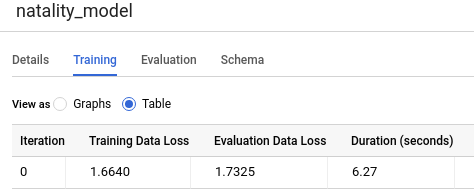

La columna Training Data Loss representa la métrica de pérdida calculada después de que se entrena el modelo en el conjunto de datos de entrenamiento. Como se realizó una regresión lineal, esta columna es el error cuadrático medio. 

La columna Evaluation Data Loss es la misma métrica de pérdida calculada en el conjunto de datos de exclusión (datos que se usan a fin de validar el modelo y, por lo tanto, no se incluyen en el entrenamiento). 

La estrategia de optimización “normal_equation” se usa automáticamente para el entrenamiento, por lo que solo se requiere una iteración a fin de converger al modelo final. Para obtener más detalles sobre la opción optimize_strategy, consulta la declaración CREATE MODEL.

Para obtener más detalles sobre la función ML.TRAINING_INFO y la opción de entrenamiento “optimize_strategy”, consulta la referencia de sintaxis de BigQuery ML (https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create).

## Paso 4: Evaluación del modelo

Después de crear el modelo, evaluamos su rendimiento con la función `ML.EVALUATE`. 

La función `ML.EVALUATE` compara los valores predichos con a los datos reales.

La consulta que se usa para evaluar el modelo es la siguiente:

<code>
#standardSQL
SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_tutorial.natality_model`,
    (
    SELECT
      weight_pounds,
      is_male,
      gestation_weeks,
      mother_age,
      CAST(mother_race AS STRING) AS mother_race
    FROM
      `bigquery-public-data.samples.natality`
    WHERE
      weight_pounds IS NOT NULL))
</code>    

SELECT recupera las columnas del modelo.

FROM usa la función `ML.EVALUATE` en sobre el modelo: bqml_tutorial.natality_model.

La declaración SELECT anidada de esta consulta y la cláusula FROM son las mismas que las de la consulta CREATE MODEL.

WHERE weight_pounds IS NOT NULL excluye las filas cuyo peso es NULL.


**Nota: La evaluación adecuada debería hacerse en un subconjunto de registros de la tabla de natalidad que esté separado de los datos usados para entrenar el modelo. A fin de simplificar, este paso se omite en este instructivo**

También podemos llamar a `ML.EVALUATE` sin proporcionar los datos de entrada. Utilizará las métricas de evaluación calculadas durante el entrenamiento:

<code>
#standardSQL
SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_tutorial.natality_model`)
</code>    

Ejecutemos los pasos que se describen en este enlace:

https://cloud.google.com/bigquery-ml/docs/bigqueryml-natality#run_the_mlevaluate_query

### Paso 5: Predicciones

Ahora que ya evaluamos el modelo, el siguiente paso es usarlo para predecir un resultado. 

Usaremos el modelo para predecir el peso de todos los bebés recién nacidos en Wyoming.

La consulta usada para predecir el resultado es la siguiente:

<code>
#standardSQL
SELECT
  predicted_weight_pounds
FROM
  ML.PREDICT(MODEL `bqml_tutorial.natality_model`,
    (
    SELECT
      is_male,
      gestation_weeks,
      mother_age,
      CAST(mother_race AS STRING) AS mother_race
    FROM
      `bigquery-public-data.samples.natality`
    WHERE
      state = "WY"))
</code>    

SELECT recupera la columna predicted_weight_pounds. Esta columna se genera mediante la función `ML.PREDICT`. 

Cuando usamos la función ML.PREDICT, el nombre de la columna de salida para el modelo es predicted_<label_column_name>. Para los modelos de regresión lineal, predicted_label es el valor estimado de label. Para los modelos de regresión logística, predicted_label es una de las dos etiquetas de entrada, según la etiqueta que tenga la mayor probabilidad predicha.

La función `ML.PREDICT` se usa para predecir resultados con el modelo bqml_tutorial.natality_model.

La declaración SELECT anidada de esta consulta y la cláusula FROM son las mismas que las de la consulta CREATE MODEL.

WHERE state = "WY" indica que estamos limitando la predicción al estado de Wyoming.

Ejecutemos los pasos que se describen en este enlace:

https://cloud.google.com/bigquery-ml/docs/bigqueryml-natality#run_the_mlpredict_query

### Paso 6: Deploy (futuro?)

Les dejamos dos links a la documentación para exportar los modelos entrenados. 

Está en beta, así que posiblemente puede cambiar o tener asistencia limitada.

https://cloud.google.com/bigquery-ml/docs/export-model-tutorial?authuser=2
    
https://cloud.google.com/bigquery-ml/docs/exporting-models?authuser=2

### Paso 7: Clean-up
    
Es importante que liberemos los recursos que utilizamos para evitar costos innecesarios (aunque en esta cuenta todo es gratis)

Podemos hacerlo siguiendo estos pasos

https://cloud.google.com/bigquery-ml/docs/bigqueryml-natality#clean-up
        

## Paso 8: Extra

Si queremos ver los coeficientes del modelo lineal entrenado usamos    
    
<code>    
SELECT *
FROM ML.WEIGHTS(MODEL `project.dataset.model_name`)
</code>

## Referencia
https://cloud.google.com/bigquery-ml/docs/bigqueryml-natality

https://sitiobigdata.com/2019/06/25/bigquery-ml/